# 1- Exploratory Data Analysis (Keşifçi Veri Analizi)

## 1.1-Veri Setini İnceleme

In [165]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from dython.data_utils import split_hist
import lightgbm as lgb

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

### Train, Test ve Sample Submission veri setleri

In [2]:
train = pd.read_csv("~/Desktop/DataThon/datasets/train.csv", parse_dates=['tarih'])
test = pd.read_csv("~/Desktop/DataThon/datasets/testFeatures.csv", parse_dates=['tarih'])
sample_sub = pd.read_csv("~/Desktop/DataThon/datasets/sample_solution.csv")

#### Train

In [3]:
train.head()

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir
0,2016-01-01,kıyma,120,et,33.41,Yurt içi,M,A
1,2016-01-01,tavuk,103,et,11.22,Yurt içi,M,A
2,2016-01-01,hindi,160,et,11.12,Yurt içi,M,A
3,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.02,Yurt içi,M,A
4,2016-01-01,Bakla-taze,72,sebze ve bakliyat,13.14,Yurt içi,M,A


In [4]:
train.shape

(227520, 8)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227520 entries, 0 to 227519
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   tarih              227520 non-null  datetime64[ns]
 1   ürün               227520 non-null  object        
 2   ürün besin değeri  227520 non-null  int64         
 3   ürün kategorisi    227520 non-null  object        
 4   ürün fiyatı        227520 non-null  float64       
 5   ürün üretim yeri   227520 non-null  object        
 6   market             227520 non-null  object        
 7   şehir              227520 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 13.9+ MB


In [6]:
train.isnull().sum()

tarih                0
ürün                 0
ürün besin değeri    0
ürün kategorisi      0
ürün fiyatı          0
ürün üretim yeri     0
market               0
şehir                0
dtype: int64

In [7]:
train["tarih"].min(), train["tarih"].max() # 5 yıllık veri seti

(Timestamp('2016-01-01 00:00:00'), Timestamp('2020-12-01 00:00:00'))

#### Test

In [8]:
test.head()

,id,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün üretim yeri,market,şehir
0,0,2021-01-01,kıyma,120,et,Yurt içi,M,A
1,1,2021-01-01,tavuk,103,et,Yurt içi,M,A
2,2,2021-01-01,hindi,160,et,Yurt içi,M,A
3,3,2021-01-01,Bakla-kuru,354,sebze ve bakliyat,Yurt içi,M,A
4,4,2021-01-01,Bakla-taze,72,sebze ve bakliyat,Yurt içi,M,A


In [9]:
test.shape

(45504, 8)

In [10]:
test.isnull().sum()

id                   0
tarih                0
ürün                 0
ürün besin değeri    0
ürün kategorisi      0
ürün üretim yeri     0
market               0
şehir                0
dtype: int64

In [11]:
test["tarih"].min(), test["tarih"].max()    # 1 yıllık veri seti

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-01 00:00:00'))

#### Sample 

In [12]:
sample_sub.head()

,id,ürün fiyatı
0,0,98.45
1,1,48.55
2,2,39.78
3,3,25.00


Üzerinde hızlı çalışılabilmesi için train ve test veri setleri birleştirildi. 

In [13]:
df = pd.concat([train, test], sort=False)

In [14]:
df.isnull().sum()

tarih                     0
ürün                      0
ürün besin değeri         0
ürün kategorisi           0
ürün fiyatı           45504
ürün üretim yeri          0
market                    0
şehir                     0
id                   227520
dtype: int64

#### Veri seti özet istatistikleri

In [15]:
df.describe(include=np.number)

,ürün besin değeri,ürün fiyatı,id
count,273024.000000,227520.000000,45504.000000
mean,143.113924,16.348622,22751.500000
std,133.218822,13.260935,13136.017661
min,8.000000,0.730000,0.000000
25%,41.000000,7.330000,11375.750000
50%,83.000000,12.600000,22751.500000
75%,250.000000,20.900000,34127.250000
max,402.000000,141.330000,45503.000000


## 1.2-Numerik ve Kategorik Değişkenlerin Analizi

grab_col_names() fonksiyonu bir dataframedeki değişkenlerin türlerini göstermek için kullanılır.

In [16]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
  
    return cat_cols, num_cols, cat_but_car

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

##### Kategorik Değişkenler

In [18]:
cat_cols

['ürün kategorisi', 'ürün üretim yeri', 'market', 'şehir']

##### Numerik Değişkenler

In [19]:
num_cols

['tarih', 'ürün besin değeri', 'ürün fiyatı', 'id']

### 1.2.1-Kategorik Değişkenlerin Bağımlı Değişkene Göre Analizi

Veri setindeki değişkenlerin bağımlı değişkenle olan beklenen korelasyonu incelenerek, yüksek korelasyon değerlerine sahip kategorik değişkenler bu bölümde incelenecektir.

cat_summary() veri setindeki kategorik değişkenlerin dağılımını veren özet fonksiyonudur.

In [20]:
def cat_summary(dataframe, col_name, target_col):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe),
                        f"{target_col}"+"_Mean": df.groupby(col_name)[target_col].mean()}))

cat_distribution_plot() veri setindeki kategorik değişkenlerin bağımlı değişkene göre dağılımını gösteren grafik fonksiyonudur.

In [21]:
def cat_distribution_plot(df, cat_col, target_col):
    split_hist(df, target_col, split_by=cat_col, ylabel="Gözlem Sayısı", 
               title=f"{target_col} Değişkenine Göre {cat_col} Değişken Dağılımı", bins=25, figsize=(12.1,4))
    plt.show()

cat_analyser_plot() veri setindeki kategorik değişkenlerin dağılımı ve bağımlı değişkenle olan ilişkisini gösteren grafik fonksiyonudur.

In [22]:
def cat_analyser_plot(df, cat_col, target_col): 
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    df[cat_col].value_counts().plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[0].set_title(f"{cat_col} Dağılımı")
    axes[0].set_xlabel(f"{cat_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    df.groupby(cat_col)[target_col].mean().plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] )
    axes[1].set_title(f"{cat_col}"+" "+"Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{cat_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.xticks(rotation=0)
    plt.show()
    
    cat_distribution_plot(df, cat_col, target_col)   

#### Ürün üretim yeri değişkeni istatistikleri

In [23]:
cat_summary(df, "ürün üretim yeri", "ürün fiyatı")

           ürün üretim yeri  Ratio  ürün fiyatı_Mean
Yurt dışı            136512   50.0         16.330241
Yurt içi             136512   50.0         16.367004


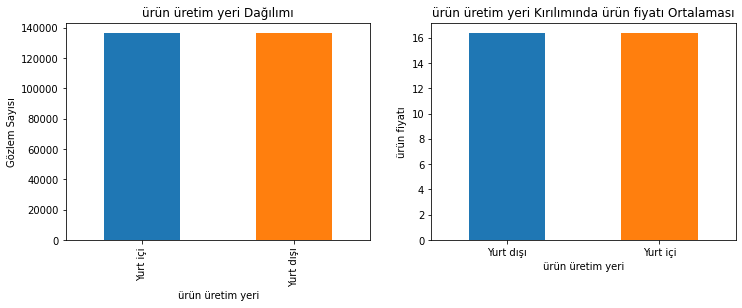

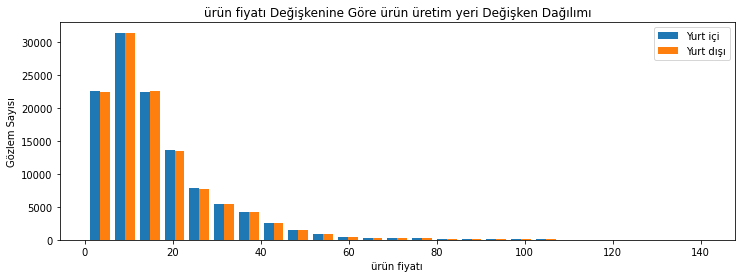

In [24]:
cat_analyser_plot(df, "ürün üretim yeri", "ürün fiyatı")

Yukarıdaki grafiklerden anlaşılacağı üzere, ürünlerin üretilme yeri dağılımları eşit görülmektedir. Ürünlerin üretilme yerlerinin bağımlı değişkene göre dağılımı da yine benzer olduğu görülebilir. Ayrıca, ürün fiyat dağılımının 10-15 aralığında yoğunlaştığı söylenebilir.

#### Ürün kategorisi değişken istatistikleri

In [25]:
cat_summary(df, "ürün kategorisi", "ürün fiyatı")

                             ürün kategorisi      Ratio  ürün fiyatı_Mean
et                                     10368   3.797468         35.722958
kuruyemiş                              17280   6.329114         30.049149
meyve                                  62208  22.784810          9.992867
sebze ve bakliyat                     100224  36.708861         14.909769
süt ürünleri ve kahvaltılık            41472  15.189873         25.619672
tahıl ve ürünleri                      41472  15.189873          9.536299


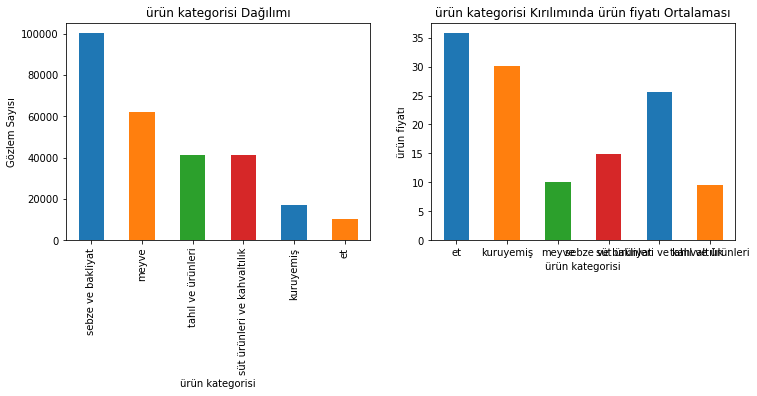

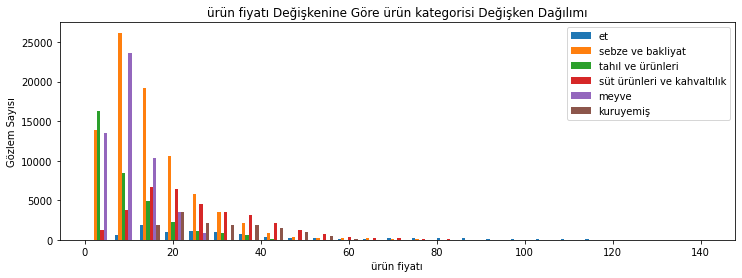

In [26]:
cat_analyser_plot(df, "ürün kategorisi", "ürün fiyatı")

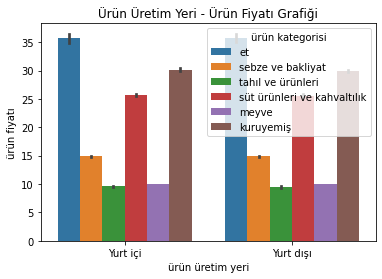

In [27]:
plt.title("Ürün Üretim Yeri - Ürün Fiyatı Grafiği")
sns.barplot(x= "ürün üretim yeri", y= "ürün fiyatı", hue= "ürün kategorisi", data=df);

Veri setinde ürün kategorisi bazında sebze ve bakliyat ürünlerin çoğunlukta olduğu görülebilir. Buna karşın, ürün fiyatı (bağımlı değişken) ortalamasına göre et ürünlerinin daha pahallı olduğu görülebilir. 

In [28]:
cat_summary(df, "market", "ürün fiyatı")

   market      Ratio  ürün fiyatı_Mean
B   91008  33.333333         16.399465
C   91008  33.333333         16.315214
M   91008  33.333333         16.331189


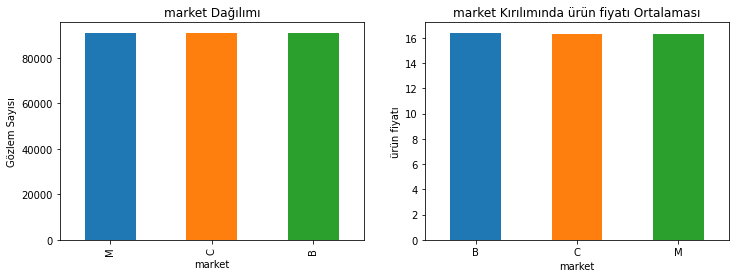

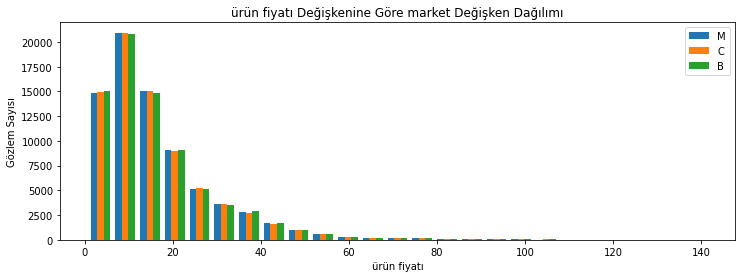

In [29]:
cat_analyser_plot(df, "market", "ürün fiyatı")

#### Market-Ürün kategorisinde fiyat değişim grafiği

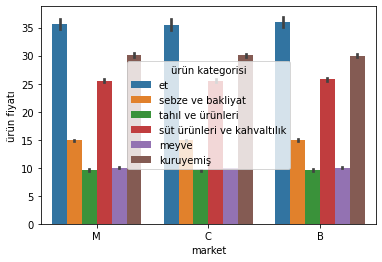

In [30]:
sns.barplot(x= "market", y= "ürün fiyatı", hue= "ürün kategorisi", data=df);

**Marketlerdeki ürün dağılımı ve ürün fiyatı dağılımı** incelendiğinde her 3 markette de aynı olduğu görülebilir. **Veri setinin sentetik olarak üretilmesinden** kaynaklı bu ve benzeri dağılıma sahip değişkenlerin bağımlı değişken üzerinde önemli bir rolü **olmaması** beklenir.

#### Şehir-Ürün kategorisinde fiyat değişim grafiği

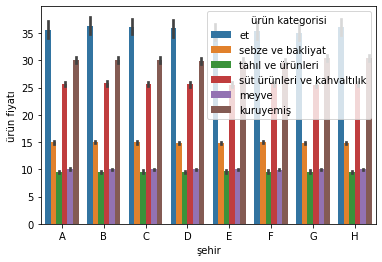

In [31]:
sns.barplot(x= "şehir", y= "ürün fiyatı", hue= "ürün kategorisi", data=df);

**Şehirlerdeki ürün dağılımı ve ürün fiyatı dağılımı** incelendiğinde 8 şehirde de yaklaşık olarak aynı olduğu görülebilir. **Veri setinin sentetik olarak üretilmesinden** kaynaklı bu ve benzeri dağılıma sahip değişkenlerin bağımlı değişken üzerinde önemli bir rolü **olmaması** beklenir

### 1.2.2-Nümerik Değişkenlerin Bağımlı Değişkene Göre Analizi

Bu bölümde, veri setindeki bağımlı değişken dışında tek nümerik değişken olan ürün besin değeri değişkeninin analizi yapılmıştır.

num_summary() veri setindeki nümerik değişkenlerin dağılımını veren özet fonksiyonudur.

In [32]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print("\t\t\t"+f"{numerical_col}"+" Nümerik Değişken Özet İstatistiği")
    print("\t\t\t---------------------------------------------")
    print(pd.DataFrame(dataframe[numerical_col].describe(quantiles)).T, "\n")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

num_analyser_plot() veri setindeki nümerik değişkenlerin dağılımı ve bağımlı değişkenle olan ilişkisini gösteren grafik fonksiyonudur.

In [33]:
def num_analyser_plot(df, num_col, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(df[num_col], kde=True, bins=30, ax=axes[0]);
    axes[0].lines[0].set_color('green')
    axes[0].set_title(f"{num_col}"+" "+"Dağılımı")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    quantiles = [0, 0.25, 0.50, 0.75, 1]
    num_df = df.copy()
    num_df[f"{num_col}"+"_CAT"] = pd.qcut(df[num_col], q=quantiles) # nümerik değişken kategorize edildi.
    df_2 = num_df.groupby(f"{num_col}"+"_CAT")[target_col].mean()
    
    sns.barplot(x=df_2.index, y=df_2.values);
    axes[1].set_title(f"{num_col} Kırılımında {target_col} Ortalaması")
    axes[1].set_ylabel(f"{target_col}")

    plt.show()

			ürün besin değeri Nümerik Değişken Özet İstatistiği
			---------------------------------------------
                      count        mean         std  min    5%   10%   20%   30%   40%   50%    60%    70%    80%    90%    95%    99%    max
ürün besin değeri  273024.0  143.113924  133.218822  8.0  17.0  24.0  35.0  42.0  57.0  83.0  110.0  160.0  350.0  368.0  390.0  402.0  402.0 



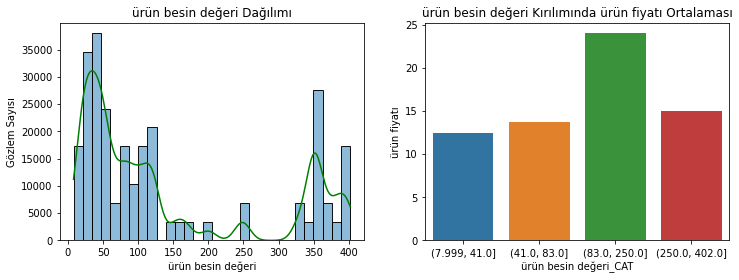

In [34]:
num_summary(df, "ürün besin değeri")
num_analyser_plot(df, "ürün besin değeri", "ürün fiyatı")

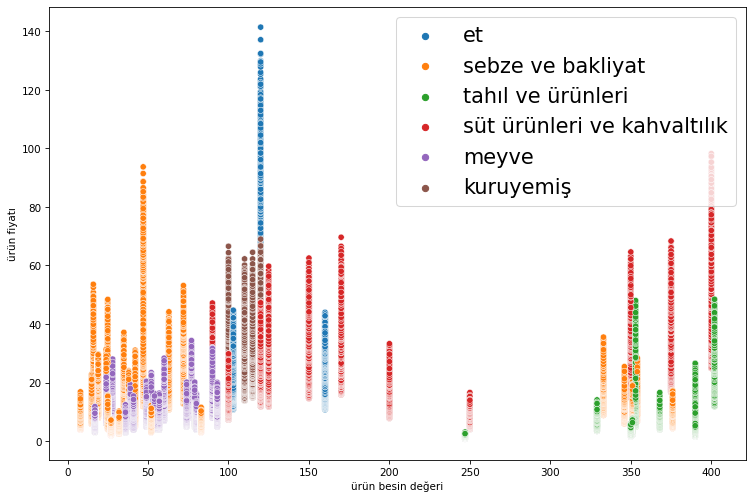

In [35]:
plt.figure(dpi=75, figsize=(12,8))
sns.scatterplot(x= "ürün besin değeri", y= "ürün fiyatı", hue= "ürün kategorisi", data= df);
plt.legend(fontsize=20, loc=1);

Grafiklere göre, veri setinde ürün besin değeri düşük olanlarn çoğunlukta olduğu görülebilir. Ürünlere ait besin değerlerinde orta-yüksek (3. segment) olanların ortalama olarak daha pahallı olduğu görülebilir.

# 2-Feature Engineering (Özellik Mühendisliği)

Buraya kadarki kısım, Veri setine ilk bakışla ilgiliydi. EDA olarak da tanımlanan buraya kadarki kısımda veri üzerinde herhangi bir değişiklik yapılmadı

Feature Engineering bölümüyle ile birlikte veri seti, geliştirilecek model için sayısallaştırılacaktır.

#### Tüm Ürün Kategorilerinde Zamana Bağlı Değişim Grafiği

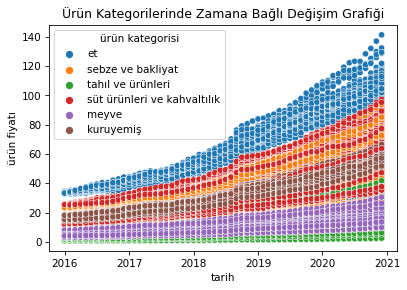

In [36]:
plt.figure(dpi=75)
plt.title("Ürün Kategorilerinde Zamana Bağlı Değişim Grafiği")
sns.scatterplot(x= "tarih", y= "ürün fiyatı", hue= df["ürün kategorisi"], data=df);

#### 2016-2021 Tarihleri Arasındaki Dolar Kuru Hareketi

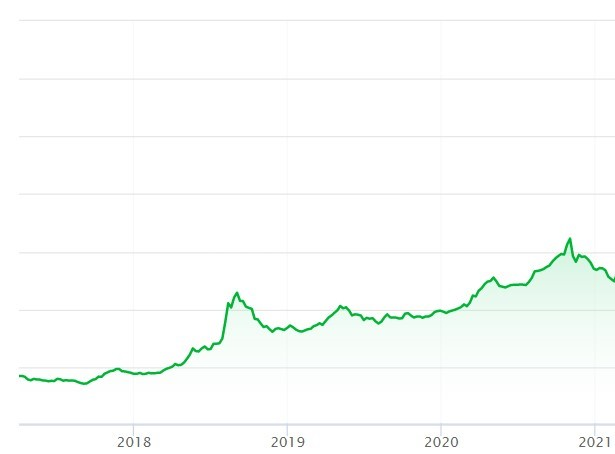

Tüm ürün kategorilerindeki zamana bağlı artış grafiği ile dolar kurunun ilgili yıllardaki değişiminin örtüştüğünü görmek mümkün. Bu sebeple, bağımlı değişkeni daha iyi açıklaması adına veri setine yeni değişken olarak dolar kuru eklenecektir. 

## 2.1-Yeni Değişkenler Ekleme & Türetme (Feature Extraction)

Bu bölüm, Keşifçi Veri Analizi bölümünde ele alınan değişkenlerin bağımlı değişken ile olan ilişkisi üzerinden, yeni değişkenler türetme aşamasıdır

3 Farklı yöntemde yeni değişkenler türetilecektir. İlk olarak veri setinde olmayan yeni değişkenler ekleme (dolar, enflasyon bilgisi), veri setindeki zaman değişkeni üzerinden yeni zaman değişkenleri türetme ve son olarak veri setindeki diğer değişkenler üzerinden nümerik ve kategorik değişkenler türetme.

In [32]:
df.head()

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir,id
0,2016-01-01,kıyma,120,et,33.41,Yurt içi,M,A,NaN
1,2016-01-01,tavuk,103,et,11.22,Yurt içi,M,A,NaN
2,2016-01-01,hindi,160,et,11.12,Yurt içi,M,A,NaN
3,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.02,Yurt içi,M,A,NaN
4,2016-01-01,Bakla-taze,72,sebze ve bakliyat,13.14,Yurt içi,M,A,NaN


### 2.1.1 Veri Setinde Olmayan Yeni Değişkenler Ekleme

Bu bölümde, veri setinde olmayan fakat bağımlı değişken (ürün fiyatı) üzerinde önemli bir ilişki olacağı düşünülen yeni değişkenler bulunup eklenecektir. 

#### Dolar Değişkeni Ekleme

Bağımlı değişkenin yıllara göre değişimi incelendiğinde, tarihsel dolar kuru ile bir ilişkisi olduğu söylenebilir. https://www.investing.com/currencies/usd-try-historical-data web sayfası üzerinden alınan dolar/tl verileri eklendi.

#### Enflasyon Değişkeni Ekleme

Bağımlı değişken üzerinde etkili olabileceği düşünülen bir diğer değişken ise enflasyon(TÜFE oranları). https://www.tcmb.gov.tr/wps/wcm/connect/TR/TCMB+TR/Main+Menu/Istatistikler/Enflasyon+Verileri/Tuketici+Fiyatlari web sayfasından alınan veriler, veri setine eklendi. 

Bu kısımla ilgili detaylı bilgi **Veriye-Yeni-Değişken-Ekleme.ipynb** dosyasından açıklanmıştır. 

Eklenen yeni değişkenler sonrası kolay kullanım için veri seti, yeni bir csv dosyası olarak kaydedildi. Elde edilen son hali şu şekildedir:

In [33]:
train = pd.read_csv("~/Desktop/DataThon/datasets/kendiTrainVerim.csv", parse_dates=['tarih'], index_col=[0])
test = pd.read_csv("~/Desktop/DataThon/datasets/kendiTestVerim.csv", parse_dates=['tarih'], index_col=[0])
df = pd.concat([train, test], sort=False, ignore_index=True)

In [34]:
df.head()

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir,Price,yillik tufe,aylık tufe,id
0,2016-01-01,kıyma,120,et,33.41,Yurt içi,M,A,2.9139,9.58,1.82,NaN
1,2016-01-01,tavuk,103,et,11.22,Yurt içi,M,A,2.9139,9.58,1.82,NaN
2,2016-01-01,hindi,160,et,11.12,Yurt içi,M,A,2.9139,9.58,1.82,NaN
3,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.02,Yurt içi,M,A,2.9139,9.58,1.82,NaN
4,2016-01-01,Bakla-taze,72,sebze ve bakliyat,13.14,Yurt içi,M,A,2.9139,9.58,1.82,NaN


Price değişkeni, ilgili tarihe ait dolar kurunu, yillik tufe ve aylık tufe değişkenleri ise enflasyon bilgisini vermektedir.

#### Yeni Eklenen Değişkenler Sonrası Korelasyon Analizi

Korelasyon grafiği, veri setinde olmayan yeni değişkenlerin eklenmesi sonrası tüm değişkenlerin birbiri arasındaki ilişkileri gösteren heat map'tir.

In [35]:
df_copy = df.drop(["id"], axis=1).copy()  # id değişkenini dışında tuttuk. 
df_corr = df_copy.corr(method ='pearson')

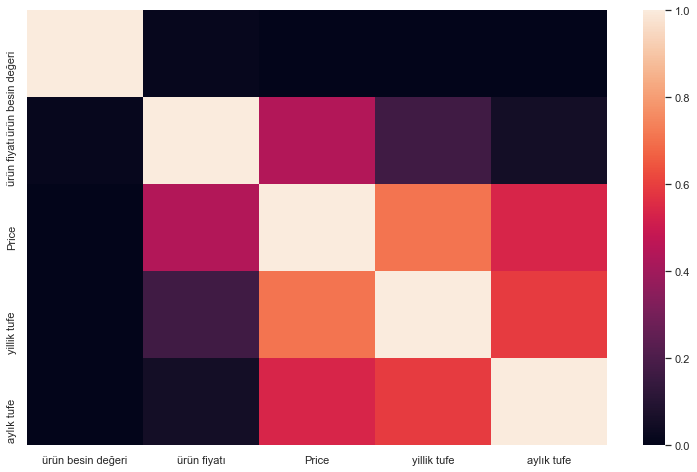

In [36]:
sns.set(rc = {'figure.figsize':(13,8)})
sns.heatmap(df_corr);

Görüldüğü üzere yeni eklenen dolar kuru ve enflasyon değişkenleri ürün fiyatını açıklamada daha iyi (korelasyon değerleri daha yüksek)

### 2.1.2 Veri Setinde Olan Değişkenler Üzerinden Yeni Değişkenler Türetme

Var olan değişkenler üzerinden türetilecek olan yeni değişkenlerle, bağımlı değişken ile arasında anlamlı çıkarımlar kurulması amaçlanacaktır.

Bu bölümde, türetilecek değişkenler iki kısıma ayrılacaktır. Zaman Serisi problemi olduğundan bu ikiye ayrım; zaman değişkeninden türetilen değişkenler ve diğer değişkenler üzerinden türetilecek değişkenler olacaktır. 

#### 2.1.2.1-Yeni Zaman Değişkenleri Türetme

tarih değişkeninden yeni değişkenlerin türetilmesi aşamasıdır.

##### tarih Değişkeninden Nümerik ve Kategorik Değişkenler Türetme

create_date_features( ) fonksiyonu, zaman değişkeni üzerinden yeni zaman değişkenlerinin türetilmesini sağlayan fonksiyondur.

In [37]:
def create_date_features(df):
    df['month'] = df.tarih.dt.month
    df['day_of_year'] = df.tarih.dt.dayofyear  # yılın kaçıncı günü
    df['week_of_year'] = df.tarih.dt.weekofyear # yılın kaçıncı haftası
    df['day_of_week'] = df.tarih.dt.dayofweek  # haftanın kaçıncı günü
    df['year'] = df.tarih.dt.year  # tarih
    df["is_wknd"] = df.tarih.dt.weekday // 4   # hafta sonu mu?
    df['is_month_start'] = df.tarih.dt.is_month_start.astype(int)  # ay başı mı?
    df['is_month_end'] = df.tarih.dt.is_month_end.astype(int)  # ay sonu mu?
    return df

In [38]:
df = create_date_features(df)

##### Zamanda Kaydırma (Shift) ile Yeni Değişkenler Türetme

random_noise () fonksiyonu ile kaydırmalı türetilecek değişkenlerde aşırı öğrenmenin (overfitting) önüne geçilmeye çalışılacaktır.

In [39]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

lag_features () fonksiyonu, ürün fiyatında tarihsel olarak kaydırma yapılıp bu değerler yeni değişkene atılacaktır. Zamanın belirli bir aralığında bağımlı değişken üzerinde bir etkisi olup olmadığı incelenecektir. Bu sayede, veri setindeki mevsimsellik yakalanmaya çalışılacaktır. 

In [40]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['ürün_fiyat_lag_' + str(lag)] = dataframe.groupby(["ürün", "ürün kategorisi", "ürün üretim yeri", "şehir", "market"])['ürün fiyatı'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [41]:
df = lag_features(df, [1, 2, 3, 4, 5, 6, 7, 8, 9])  # Her bir kaydırma 1 aylık bir dönemi kapsamaktadır.

In [42]:
df.head()

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir,Price,yillik tufe,aylık tufe,id,month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,ürün_fiyat_lag_1,ürün_fiyat_lag_2,ürün_fiyat_lag_3,ürün_fiyat_lag_4,ürün_fiyat_lag_5,ürün_fiyat_lag_6,ürün_fiyat_lag_7,ürün_fiyat_lag_8,ürün_fiyat_lag_9
0,2016-01-01,kıyma,120,et,33.41,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,tavuk,103,et,11.22,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,hindi,160,et,11.12,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.02,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,Bakla-taze,72,sebze ve bakliyat,13.14,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Zamanda Hareketli Ortalama (Rolling Mean) ile Yeni Değişkenler Türetme

roll_mean_features () fonksiyonu, zamanda belirli miktarda (1 shift/ay) kaydırılmış zaman serisi üzerinde hareketli ortalama alınmasını sağlamaktadır. 

In [43]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['fiyat_roll_mean_' + str(window)] = dataframe.groupby(["ürün", "ürün kategorisi", "ürün üretim yeri", "şehir", "market"])['ürün fiyatı']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [44]:
df = roll_mean_features(df, [1, 2, 3, 4, 5, 6]) # Shift edilmiş gözlemden ne kadar önceki değerler ile ortalama alınacağı verilir.

ewm_features(), zaman serisinde hareketli ortalama alınırken geçmiş değerleri ağırlıklandırarak yapılmasını sağlayan fonksiyondur.

In [45]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['fiyat_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["ürün", "ürün kategorisi", "ürün üretim yeri", "şehir", "market"])['ürün fiyatı'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [46]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]  # Ağırlıklandırma katsayıları. 
lags = [2, 3, 4, 5, 6, 7, 8]      # Shift değerleri

In [47]:
df = ewm_features(df, alphas, lags)

In [48]:
df.head()

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir,Price,yillik tufe,aylık tufe,id,month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,ürün_fiyat_lag_1,ürün_fiyat_lag_2,ürün_fiyat_lag_3,ürün_fiyat_lag_4,ürün_fiyat_lag_5,ürün_fiyat_lag_6,ürün_fiyat_lag_7,ürün_fiyat_lag_8,ürün_fiyat_lag_9,fiyat_roll_mean_1,fiyat_roll_mean_2,fiyat_roll_mean_3,fiyat_roll_mean_4,fiyat_roll_mean_5,fiyat_roll_mean_6,fiyat_ewm_alpha_095_lag_2,fiyat_ewm_alpha_095_lag_3,fiyat_ewm_alpha_095_lag_4,fiyat_ewm_alpha_095_lag_5,fiyat_ewm_alpha_095_lag_6,fiyat_ewm_alpha_095_lag_7,fiyat_ewm_alpha_095_lag_8,fiyat_ewm_alpha_09_lag_2,fiyat_ewm_alpha_09_lag_3,fiyat_ewm_alpha_09_lag_4,fiyat_ewm_alpha_09_lag_5,fiyat_ewm_alpha_09_lag_6,fiyat_ewm_alpha_09_lag_7,fiyat_ewm_alpha_09_lag_8,fiyat_ewm_alpha_08_lag_2,fiyat_ewm_alpha_08_lag_3,fiyat_ewm_alpha_08_lag_4,fiyat_ewm_alpha_08_lag_5,fiyat_ewm_alpha_08_lag_6,fiyat_ewm_alpha_08_lag_7,fiyat_ewm_alpha_08_lag_8,fiyat_ewm_alpha_07_lag_2,fiyat_ewm_alpha_07_lag_3,fiyat_ewm_alpha_07_lag_4,fiyat_ewm_alpha_07_lag_5,fiyat_ewm_alpha_07_lag_6,fiyat_ewm_alpha_07_lag_7,fiyat_ewm_alpha_07_lag_8,fiyat_ewm_alpha_05_lag_2,fiyat_ewm_alpha_05_lag_3,fiyat_ewm_alpha_05_lag_4,fiyat_ewm_alpha_05_lag_5,fiyat_ewm_alpha_05_lag_6,fiyat_ewm_alpha_05_lag_7,fiyat_ewm_alpha_05_lag_8
0,2016-01-01,kıyma,120,et,33.41,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,tavuk,103,et,11.22,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,hindi,160,et,11.12,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.02,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,Bakla-taze,72,sebze ve bakliyat,13.14,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.1.2.1-Diğer Değişkenlerden Yeni Değişkenler Türetme

Bu bölümde, veri setindeki zaman değişkeni dışındaki değişkenler üzerinden yeni kategorik ve nümerik değişkenler türetilecektir. 

#### ürün besin değeri Değişkeni ile Kategorik Değişken Türetme

ürün besin değeri, bağımlı değişken olan ürün fiyatı değişkeni üzerinde etkisinin olacağı beklenir. Bu sebeple, nümerik olan bu değişkenden yeni kategorik değişken türeterek eğitilecek model için anlamlı bir değişken olması beklenir.

In [49]:
df['ürün besin değeri'].describe()

count    273024.000000
mean        143.113924
std         133.218822
min           8.000000
25%          41.000000
50%          83.000000
75%         250.000000
max         402.000000
Name: ürün besin değeri, dtype: float64

In [50]:
df["NEW_besin_değeri"] = pd.qcut(df['ürün besin değeri'], 4, labels=['poor','average','rich','super_rich'])

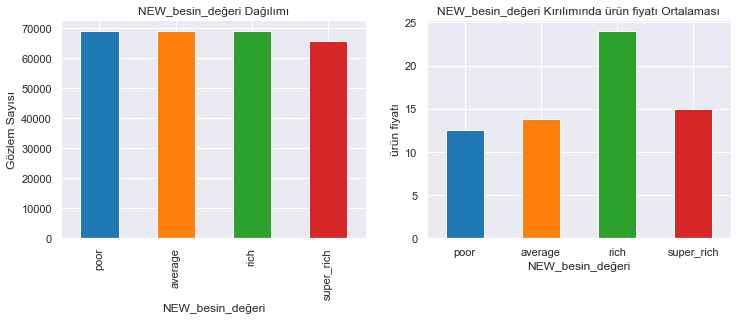

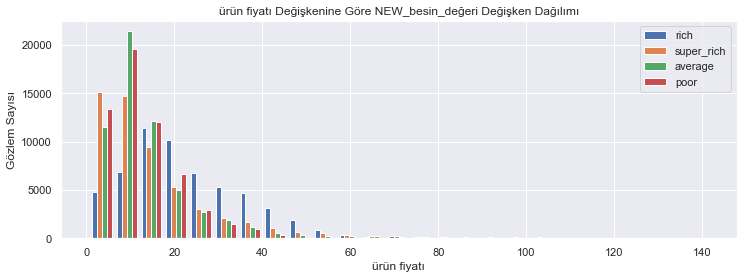

In [51]:
cat_analyser_plot(df, "NEW_besin_değeri", "ürün fiyatı")

ürün besin değeri rich kategorisinde olan ürünlerin ortalama fiyatı, diğer kategorilere oranla daha yüksek.

#### ürün besin değeri ve ürün fiaytı Değişkenleri ile Nümerik Değişken Türetme

In [52]:
df["NEW_uniq_price"] = df["ürün besin değeri"] / df["ürün fiyatı"]

In [53]:
df.head()

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir,Price,yillik tufe,aylık tufe,id,month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,ürün_fiyat_lag_1,ürün_fiyat_lag_2,ürün_fiyat_lag_3,ürün_fiyat_lag_4,ürün_fiyat_lag_5,ürün_fiyat_lag_6,ürün_fiyat_lag_7,ürün_fiyat_lag_8,ürün_fiyat_lag_9,fiyat_roll_mean_1,fiyat_roll_mean_2,fiyat_roll_mean_3,fiyat_roll_mean_4,fiyat_roll_mean_5,fiyat_roll_mean_6,fiyat_ewm_alpha_095_lag_2,fiyat_ewm_alpha_095_lag_3,fiyat_ewm_alpha_095_lag_4,fiyat_ewm_alpha_095_lag_5,fiyat_ewm_alpha_095_lag_6,fiyat_ewm_alpha_095_lag_7,fiyat_ewm_alpha_095_lag_8,fiyat_ewm_alpha_09_lag_2,fiyat_ewm_alpha_09_lag_3,fiyat_ewm_alpha_09_lag_4,fiyat_ewm_alpha_09_lag_5,fiyat_ewm_alpha_09_lag_6,fiyat_ewm_alpha_09_lag_7,fiyat_ewm_alpha_09_lag_8,fiyat_ewm_alpha_08_lag_2,fiyat_ewm_alpha_08_lag_3,fiyat_ewm_alpha_08_lag_4,fiyat_ewm_alpha_08_lag_5,fiyat_ewm_alpha_08_lag_6,fiyat_ewm_alpha_08_lag_7,fiyat_ewm_alpha_08_lag_8,fiyat_ewm_alpha_07_lag_2,fiyat_ewm_alpha_07_lag_3,fiyat_ewm_alpha_07_lag_4,fiyat_ewm_alpha_07_lag_5,fiyat_ewm_alpha_07_lag_6,fiyat_ewm_alpha_07_lag_7,fiyat_ewm_alpha_07_lag_8,fiyat_ewm_alpha_05_lag_2,fiyat_ewm_alpha_05_lag_3,fiyat_ewm_alpha_05_lag_4,fiyat_ewm_alpha_05_lag_5,fiyat_ewm_alpha_05_lag_6,fiyat_ewm_alpha_05_lag_7,fiyat_ewm_alpha_05_lag_8,NEW_besin_değeri,NEW_uniq_price
0,2016-01-01,kıyma,120,et,33.41,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rich,3.591739
1,2016-01-01,tavuk,103,et,11.22,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rich,9.180036
2,2016-01-01,hindi,160,et,11.12,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rich,14.388489
3,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.02,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,super_rich,50.427350
4,2016-01-01,Bakla-taze,72,sebze ve bakliyat,13.14,Yurt içi,M,A,2.9139,9.58,1.82,NaN,1,1,53,4,2016,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,average,5.479452


## 2.2-Encoding İşlemleri

Bu bölüm, veri setindeki kategorik değişkenlerin model tarafından anlaşılabilir formatta olacak şekilde encode edilmesi aşamasıdır. One-Hot ve Rare Encoding işlemleri yapılacaktır.

### 2.2.1-One Hot Encoding

2'den fazla benzersiz(uniq) gözleme sahip kategorik değişkenlerin encode edilmesi aşamasıdır.

In [54]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]  # One-Hot encoding için uygun değişkenler
ohe_cols

['ürün kategorisi',
 'market',
 'şehir',
 'day_of_week',
 'year',
 'NEW_besin_değeri']

In [55]:
ohe_cols.append("ürün") 
ohe_cols.append("ürün üretim yeri") # Bu değişkenlerin de encode edilmesi gerek.

In [56]:
ohe_cols

['ürün kategorisi',
 'market',
 'şehir',
 'day_of_week',
 'year',
 'NEW_besin_değeri',
 'ürün',
 'ürün üretim yeri']

In [57]:
df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)

In [58]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

### 2.2.2-Rare Encoding

Bağımlı değişkene göre dağılımı seyrek olan değişken gözlemlerinin (varsa) birarada encode edilmesidir.

In [59]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [60]:
#rare_analyser(df, "ürün fiyatı", cat_cols)

Rare olarak kabul edilebilecek (ratio < 0.01 seviyede) herhangi bir değişken gözlemi gözükmüyor.

In [61]:
df.shape

(273024, 171)

Modelden oluşturmadan önce, Feature Extraction aşamasında dataframe değişken sayısının 8'den 176'ya çıkarıldığı görülebilir.

# 3-Model Oluşturma ve Test

Bu aşamada, Keşifçi Veri Analizi ve Özellik Mühendisliği bölümlerinde hazırlanan veri seti üzerinde **LightGBM** makine öğrenmesi algoritması kullanarak model geliştirilecektir.

## 3.1-Hata Metriğinin Hazırlanması ve Validasyon

### 3.1.1-Hata Metriği

Bu aşamada, kullanılacak model için validasyon yapıldığında model doğruluğunu ölçmek için **SMAPE hata metriği** kullanılacaktır.

In [62]:
df['ürün fiyatı'] = np.log1p(df["ürün fiyatı"].values)  # Modelde sağlıklı sonuç vermesi için logaritmasını alındı.

In [63]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

### 3.1.2-Validasyon

Modelin, test veri setinde nasıl bir sonuç alabileceğini validasyon veri seti oluşturarak inceleme aşamasıdır.

In [64]:
train = df.loc[(df["tarih"] < "2020-05-01"), :]   # Validasyon-train veri setleri belirlendi.
val = df.loc[(df["tarih"] >= "2020-05-01") & (df["tarih"] <= "2020-08-01"), :]

In [65]:
cols = [col for col in train.columns if col not in ['tarih', 'id', "ürün fiyatı"]] # Bu değişkenler dışındaki değişkenler kullanılacaktır.

In [66]:
Y_train = train['ürün fiyatı']
X_train = train[cols]

In [67]:
Y_val = val['ürün fiyatı']
X_val = val[cols]

#### Model Parametreleri

In [68]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [69]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)  # model için uygun formata getirildi.
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [70]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0868405	training's SMAPE: 9.91473	valid_1's l1: 0.100485	valid_1's SMAPE: 10.519
[200]	training's l1: 0.0269293	training's SMAPE: 3.09915	valid_1's l1: 0.021985	valid_1's SMAPE: 2.31536
[300]	training's l1: 0.0191469	training's SMAPE: 2.19179	valid_1's l1: 0.0155589	valid_1's SMAPE: 1.64148
[400]	training's l1: 0.0166995	training's SMAPE: 1.90123	valid_1's l1: 0.0146429	valid_1's SMAPE: 1.54563
[500]	training's l1: 0.0155525	training's SMAPE: 1.7654	valid_1's l1: 0.0139872	valid_1's SMAPE: 1.47895
[600]	training's l1: 0.014707	training's SMAPE: 1.66619	valid_1's l1: 0.0135787	valid_1

#### Feature Perfomance 

plot_lgb_importances (), model için önemli değişkenleri sıralayıp grafikleştiren fonksiyondur.

In [71]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        print("Sum:", feat_imp["gain"].sum())

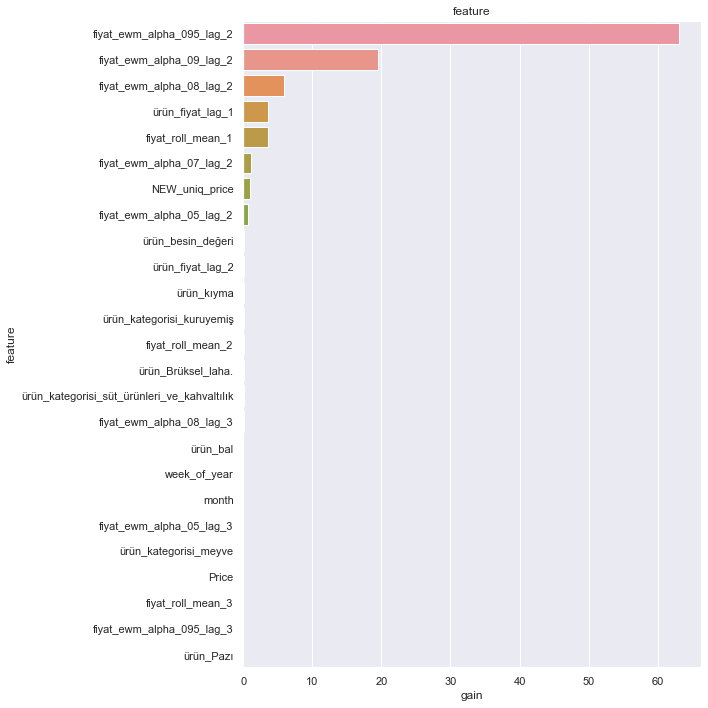

In [72]:
plot_lgb_importances(model, plot=True)

## 3.2-Tahminleme Testi

Bu aşamada, modelin hiç görmediği veri seti (test) üzerinden zamana bağlı ürün fiyat tahminlemesi yapması amaçlanmıştır.

In [73]:
train = df.loc[~df["ürün fiyatı"].isna()]  # train veri seti ayrımı yapıldı.
Y_train = train['ürün fiyatı']
X_train = train[cols]

In [74]:
test = df.loc[df["ürün fiyatı"].isna()] # test veri seti ayrımı yapıldı.
X_test = test[cols]

In [75]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 15,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              "min_data_leaf": 75,
              'max_depth': 5,
              'verbose': -1,
              'nthread': -1,
              "num_boost_round": model.best_iteration}  # Validasyon üzerinden elde edilen best iteration değerleri kullanıldı.

In [76]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols) # train veri seti modele uygun hale getirildi

In [77]:
model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration) # Model best iteration ile eğitildi

[LightGBM] [Warning] Unknown parameter: min_data_leaf


In [78]:
test_preds = model.predict(X_test, num_iteration=model.best_iteration)  # test veri setinde tahminleme

In [79]:
submission_df = test.loc[:, ['id', 'ürün fiyatı']] # Submission'a uygun hale getirildi.
submission_df['ürün fiyatı'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

In [80]:
submission_df.sort_index(inplace=True)

#### Örnek submission değerleri

In [81]:
sample_sub # Gerçek değerler

,id,ürün fiyatı
0,0,98.45
1,1,48.55
2,2,39.78
3,3,25.00


#### Elde edilen değerler

In [82]:
submission_df.sort_values("id").head(4) # Tahmin edilen değerler

,id,ürün fiyatı
227520,0,132.174252
227521,1,47.910537
227522,2,52.161120
227523,3,32.338028


Görüldüğü üzere, tahmin edilen değerler gerçek verilere oldukça yakın. 

In [84]:
submission_df.to_csv("submission.csv", index=False)  # Elde edilen sonuç veri setinin csv formatına getirilmesi